In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import logging


In [3]:
class Logger:

    def __init__(self, file_name: str, basic_level=logging.INFO):

        logger = logging.getLogger(__name__)
        logger.setLevel(basic_level)

        file_handler = logging.FileHandler(f'../logs/{file_name}')
        formatter = logging.Formatter(
            '%(asctime)s : %(levelname)s : %(name)s : %(message)s', '%m-%d-%Y %H:%M:%S')

        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        self.logger = logger

    def get_app_logger(self) -> logging.Logger:
        return self.logger

In [4]:
logger = Logger("userSatisfaction.log").get_app_logger()

In [5]:
class Display_data:
    def __init__(self) -> None:
        self.logger = Logger("plot.log", basic_level=logging.INFO)
        try:
            self.logger = Logger("plot.log").get_app_logger()
            self.logger.info(
                'Successfully Instantiated Preprocessing Class Object')
        except Exception:
            self.logger.exception(
                'Failed to Instantiate Preprocessing Class Object')
            sys.exit(1)

    def display_by_bar(self, df: pd.DataFrame, x_col: str, y_col: str, title: str, xlabel: str, ylabel: str) -> None:
        plt.figure(figsize=(12, 7))
        sns.barplot(data=df, x=x_col, y=y_col)
        plt.title(title, size=20)
        plt.xticks(rotation=75, fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(xlabel, fontsize=16)
        plt.ylabel(ylabel, fontsize=16)
        self.logger.info(
            'displaying data by bar chart')
        plt.show()


In [6]:
display = Display_data()

In [7]:
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')
df = df_org.copy()

In [8]:
user_exp = pd.read_csv('../data/user_experience.csv')
user_eng = pd.read_csv('../data/user_eng.csv')

In [9]:
with open("../models/user_eng.pkl", "rb") as f:
    kmeans1 = pickle.load(f)
    
with open("../models/user_exp.pkl", "rb") as f:
    kmeans2 = pickle.load(f)

In [10]:
user_engagement_df = user_eng.set_index('msisdn/number')[
    ['sessions','dur._(ms)', 'total_data']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_engagement_df)
pd.DataFrame(scaled_data).head(5)

,0,1,2
0,-0.488567,-0.158015,0.382288
1,-0.488567,0.188146,-1.087675
2,-0.488567,-0.060090,-0.193462
3,-0.488567,-0.516689,-0.547080
4,0.752095,-0.585234,1.560816


In [11]:
data_normalized = normalize(scaled_data)
pd.DataFrame(data_normalized).head(5)

,0,1,2
0,-0.763190,-0.246834,0.597172
1,-0.404738,0.155864,-0.901051
2,-0.923740,-0.113614,-0.365781
3,-0.544549,-0.575892,-0.609766
4,0.411264,-0.320020,0.853492


In [12]:
distance = kmeans1.fit_transform(data_normalized)
distance_from_less_engagement = list(
    map(lambda x: x[3], distance))
user_eng['engagement_score'] = distance_from_less_engagement
user_eng.head(5)

,msisdn/number,cluster,sessions,dur._(ms),total_data,engagement_score
0,3.360100e+10,0,1,116720.0,8.786906e+08,1.638161
1,3.360100e+10,2,1,181230.0,1.568596e+08,1.652937
2,3.360100e+10,0,1,134969.0,5.959665e+08,1.819934
3,3.360101e+10,0,1,49878.0,4.223207e+08,1.934161
4,3.360101e+10,0,2,37104.0,1.457411e+09,1.169013


In [13]:
len(user_exp)

106856

In [14]:
user_expr = user_exp.copy()
user_expr.drop([106855], axis=0, inplace=True)

In [15]:
exp_df = user_expr.set_index('msisdn/number')
distance = kmeans2.fit_transform(data_normalized)
distance_from_worest_experiance = list(
    map(lambda x: x[0], distance))
user_expr['experience_score'] = distance_from_worest_experiance
user_expr.head(5)

,msisdn/number,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score
0,3.360100e+10,8.114390,7.274480,23.201031,0.437560
1,3.360100e+10,3.401197,7.803027,23.201031,1.263870
2,3.360100e+10,5.416100,7.763021,23.201031,0.640821
3,3.360101e+10,6.942157,9.102310,16.921539,0.840732
4,3.360101e+10,8.114390,27.135851,49.213729,1.341616


In [16]:
user_eng_id = user_eng['msisdn/number'].values
user_expr_id = user_expr['msisdn/number'].values
user_intersection = list(
    set(user_eng_id).intersection(user_expr_id))
user_intersection[:5]

[33662697474.0, 33665581058.0, 33628094468.0, 33666105351.0, 33782497288.0]

In [17]:
user_eng_df = user_eng[user_eng['msisdn/number'].isin(
    user_intersection)]

In [18]:
user_eng_df.shape

(106854, 6)

In [19]:
user_exper_df = user_expr[user_expr['msisdn/number'].isin(
    user_intersection)]

In [20]:
user_exper_df.shape

(106854, 5)

In [21]:
user_df = pd.merge(user_eng_df, user_exper_df, on='msisdn/number')
user_df['satisfaction_score'] = (
    user_df['engagement_score'] + user_df['experience_score'])/2
user_df.head(5)

,msisdn/number,cluster,sessions,dur._(ms),total_data,engagement_score,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,3.360100e+10,0,1,116720.0,8.786906e+08,1.638161,8.114390,7.274480,23.201031,0.437560,1.037860
1,3.360100e+10,2,1,181230.0,1.568596e+08,1.652937,3.401197,7.803027,23.201031,1.263870,1.458404
2,3.360100e+10,0,1,134969.0,5.959665e+08,1.819934,5.416100,7.763021,23.201031,0.640821,1.230377
3,3.360101e+10,0,1,49878.0,4.223207e+08,1.934161,6.942157,9.102310,16.921539,0.840732,1.387447
4,3.360101e+10,0,2,37104.0,1.457411e+09,1.169013,8.114390,27.135851,49.213729,1.341616,1.255315


In [22]:
satisfaction_df = user_df[['msisdn/number', 'engagement_score',
                        'experience_score', 'satisfaction_score']]
satisfaction_df = satisfaction_df.set_index('msisdn/number')

In [23]:
top_10_satisfaction = satisfaction_df.nlargest(10, 'satisfaction_score')
top_10_satisfaction.head(10)

,engagement_score,experience_score,satisfaction_score
msisdn/number,,,
3.366879e+10,1.957912,1.862770,1.910341
3.366499e+10,1.956995,1.861319,1.909157
3.378363e+10,1.956059,1.861748,1.908904
3.366601e+10,1.957557,1.858154,1.907855
3.367650e+10,1.956079,1.858849,1.907464
3.378345e+10,1.957503,1.857185,1.907344
3.369864e+10,1.950349,1.862046,1.906198
3.367639e+10,1.955122,1.855984,1.905553
3.366505e+10,1.957436,1.851927,1.904682


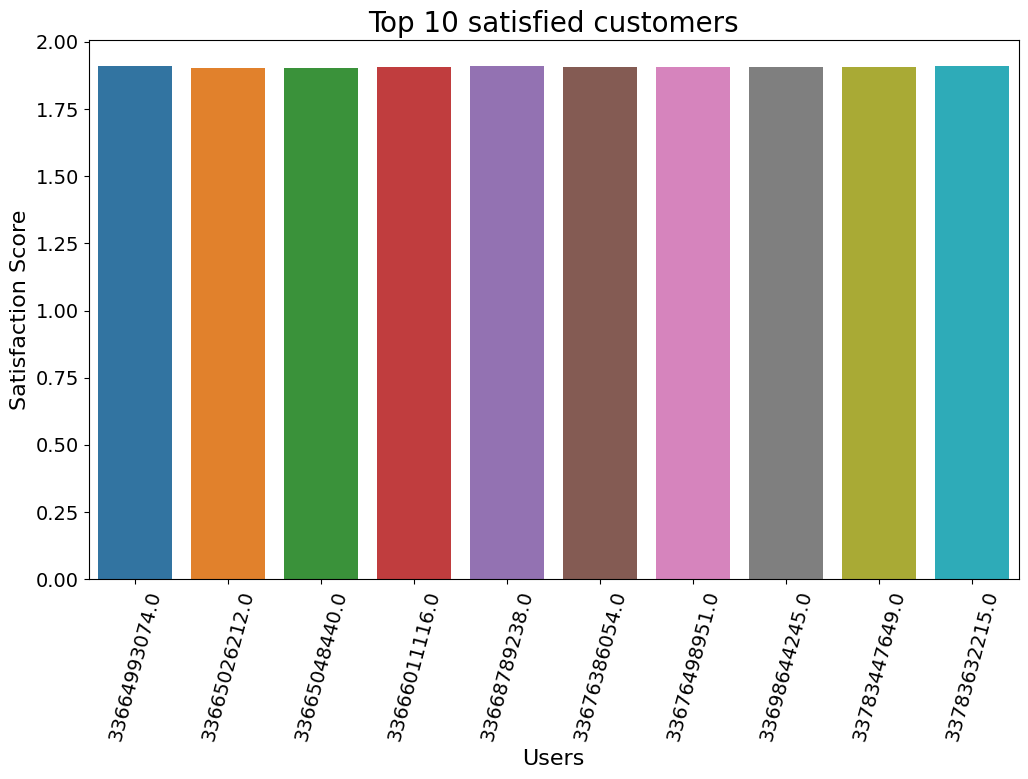

In [24]:
display.display_by_bar(top_10_satisfaction, top_10_satisfaction.index, top_10_satisfaction['satisfaction_score'],
    "Top 10 satisfied customers", "Users", "Satisfaction Score")

In [25]:
class Model:
    def __init__(self,X_train,X_test,y_train,y_test):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test


    def model(self):
        self.trained_model = LinearRegression()
        self.trained_model.fit(self.X_train, self.y_train)
        

    def predict(self):
        self.model()
        return self.trained_model.predict(self.X_test)

    def score(self):
        return self.trained_model.score(self.X_test, self.y_test)

    def error_score(self):
        return np.mean((self.trained_model.predict(self.X_test) - self.y_test) ** 2)
    
    def save_model(self, path):
        pickle.dump(self.trained_model, open(path, 'wb'))

In [26]:
engagement_score = satisfaction_df[['engagement_score', 'experience_score']]
experience_score = satisfaction_df[['satisfaction_score']]
X_train, X_test, y_train, y_test = model_selection.train_test_split(engagement_score, experience_score, test_size=0.2, random_state=42) 

In [27]:
model = Model(X_train, X_test, y_train, y_test)

In [28]:
model.predict()

array([[0.92368236],
       [1.36024534],
       [0.91737248],
       ...,
       [1.34390228],
       [1.23557379],
       [1.27115282]])

In [29]:
model.score()

1.0

In [30]:
model.error_score()

C:\Users\ACF\PycharmProjects\XDR_analysis\venv\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


satisfaction_score    5.083758e-31
dtype: float64

In [31]:
model.save_model("../models/satisfaction_model.pkl")

In [32]:
user_df.head()

,msisdn/number,cluster,sessions,dur._(ms),total_data,engagement_score,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,3.360100e+10,0,1,116720.0,8.786906e+08,1.638161,8.114390,7.274480,23.201031,0.437560,1.037860
1,3.360100e+10,2,1,181230.0,1.568596e+08,1.652937,3.401197,7.803027,23.201031,1.263870,1.458404
2,3.360100e+10,0,1,134969.0,5.959665e+08,1.819934,5.416100,7.763021,23.201031,0.640821,1.230377
3,3.360101e+10,0,1,49878.0,4.223207e+08,1.934161,6.942157,9.102310,16.921539,0.840732,1.387447
4,3.360101e+10,0,2,37104.0,1.457411e+09,1.169013,8.114390,27.135851,49.213729,1.341616,1.255315


In [33]:
user_df.head()

,msisdn/number,cluster,sessions,dur._(ms),total_data,engagement_score,avg_rtt_total,avg_tp_total,total_avg_tcp_total,experience_score,satisfaction_score
0,3.360100e+10,0,1,116720.0,8.786906e+08,1.638161,8.114390,7.274480,23.201031,0.437560,1.037860
1,3.360100e+10,2,1,181230.0,1.568596e+08,1.652937,3.401197,7.803027,23.201031,1.263870,1.458404
2,3.360100e+10,0,1,134969.0,5.959665e+08,1.819934,5.416100,7.763021,23.201031,0.640821,1.230377
3,3.360101e+10,0,1,49878.0,4.223207e+08,1.934161,6.942157,9.102310,16.921539,0.840732,1.387447
4,3.360101e+10,0,2,37104.0,1.457411e+09,1.169013,8.114390,27.135851,49.213729,1.341616,1.255315


In [ ]:
user_satisfaction_df = user_df[[
    'msisdn/number', 
    'engagement_score',
    'experience_score']]
user_satisfaction_df = user_satisfaction_df.set_index('msisdn/number')

In [105]:
user_satisfaction_df.head()

,engagement_score,experience_score
msisdn/number,,
3.360100e+10,1.638161,0.437560
3.360100e+10,1.652937,1.263870
3.360100e+10,1.819934,0.640821
3.360101e+10,1.934161,0.840732
3.360101e+10,1.169013,1.341616


In [106]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

In [107]:
user_satisfaction_df

,engagement_score,experience_score
msisdn/number,,
3.360100e+10,1.638161,0.437560
3.360100e+10,1.652937,1.263870
3.360100e+10,1.819934,0.640821
3.360101e+10,1.934161,0.840732
3.360101e+10,1.169013,1.341616
...,...,...
3.378998e+10,0.574119,0.500044
3.379000e+10,1.915817,0.913146
3.379000e+10,1.795498,1.552662


In [108]:
normalized_df = normalizer(user_satisfaction_df, ['engagement_score', 'experience_score'] )

In [109]:
normalized_sat_df = normalized_df.copy()

In [110]:
kmeans = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized_sat_df)
centroids = kmeans.cluster_centers_

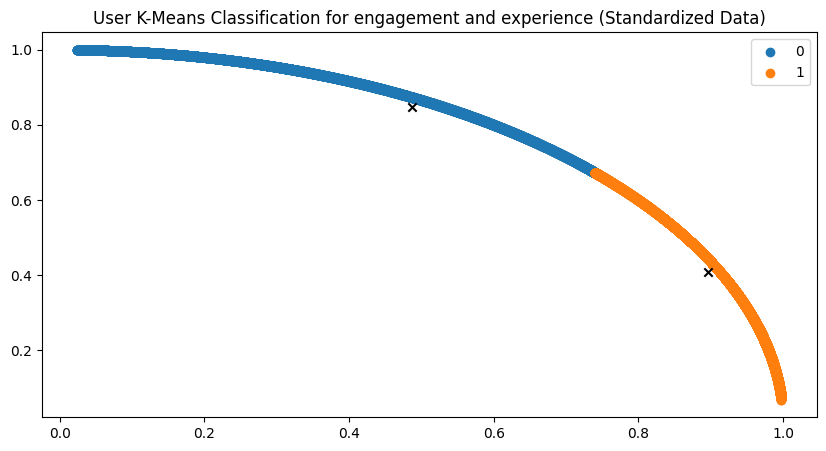

In [159]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification for engagement and experience (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized_sat_df[label == i].iloc[:,0] , normalized_sat_df[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1], marker='x', color = 'black')
plt.legend()
plt.show()

In [112]:
normalized_sat_df.head()

,engagement_score,experience_score
0,0.966130,0.258058
1,0.794390,0.607407
2,0.943236,0.332125
3,0.917106,0.398643
4,0.656943,0.753940


In [113]:
user_sat_engagement = user_satisfaction_df.copy()

In [114]:
user_sat_engagement.insert(0, 'cluster', kmeans.labels_)
user_sat_engagement.head(5)

,cluster,engagement_score,experience_score
msisdn/number,,,
3.360100e+10,1,1.638161,0.437560
3.360100e+10,1,1.652937,1.263870
3.360100e+10,1,1.819934,0.640821
3.360101e+10,1,1.934161,0.840732
3.360101e+10,0,1.169013,1.341616


In [53]:
user_sat_engagement.to_csv('../data/user_satisfaction.csv')

In [55]:
aggrigate_sat = user_sat_engagement.groupby('cluster').agg(
    {'engagement_score': 'sum', 'experience_score': 'sum'})

In [56]:
aggrigate_sat_df = pd.DataFrame()
aggrigate_sat_df['cluster'] = aggrigate_sat.index
aggrigate_sat_df['engagement_score'] = aggrigate_sat['engagement_score']
aggrigate_sat_df['experience_score'] = aggrigate_sat['experience_score']

In [58]:
aggrigate_sat_df.head()

,cluster,engagement_score,experience_score
0,0,28953.199967,48464.039624
1,1,131267.519451,61359.444367


<AxesSubplot:xlabel='cluster', ylabel='engagement_score'>

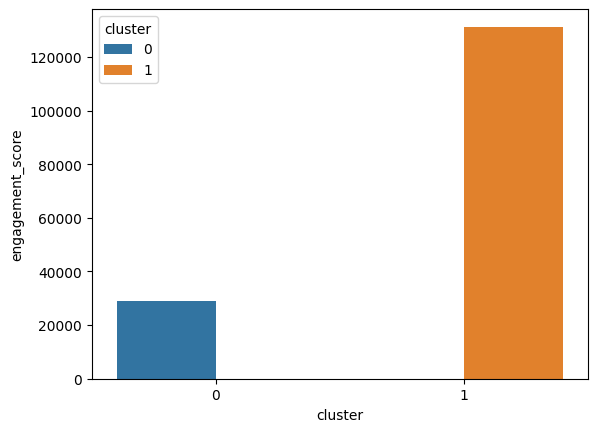

In [60]:
sns.barplot(x="cluster", y="engagement_score", hue="cluster", data=aggrigate_sat_df)

In [37]:
satisfaction_df = user_df[['msisdn/number', 'engagement_score',
                        'experience_score', 'satisfaction_score']]

In [38]:
satisfaction_df.to_csv('../data/final_table.csv')